In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler

In [13]:
df_5 = pd.read_csv('../casp 5/cleaned_casp5_boy.csv')

In [14]:
df_5.drop('Unnamed: 0',axis=1)

close_friend_count  spent_time_friend1  spent_time_friend2  \
0                    3.0                 3.0                 4.0   
1                    3.0                 0.0                 0.0   
2                    3.0                 2.0                 1.0   
3                    3.0                 0.0                 2.0   
4                    3.0                 2.0                 2.0   
...                  ...                 ...                 ...   
7080                 3.0                 2.0                 2.0   
7081                 1.0                 0.0                 0.0   
7082                 2.0                 0.0                 0.0   
7083                 3.0                 0.0                 0.0   
7084                 3.0                 1.0                 0.0   

      chatting_online  breakfast_routindays  breakfast_friday  \
0                 3.0                   6.0                 0   
1                 0.0                   3.0                 1   
2                 0.0                   6.0                 1   
3                 2.0                   3.0                 1   
4                 2.0                   4.0                 1   
...               ...                   ...               ...   
7080              2.0                   4.0                 1   
7081              1.0                   5.0                 1   
7082              1.0                   6.0                 1   
7083              0.0                   6.0                 1   
7084              1.0                   6.0                 1   

      lunch_routinday  lunch_friday  dinner_routinday  dinner_friday  ...  \
0                 1.0             1               2.0              1  ...   
1                 5.0             1               5.0              1  ...   
2                 1.0             1               6.0              1  ...   
3                 3.0             1               6.0              1  ...   
4                 0.0             1               4.0              1  ...   
...               ...           ...               ...            ...  ...   
7080              0.0             1               4.0              1  ...   
7081              5.0             1               5.0              1  ...   
7082              6.0             1               6.0              1  ...   
7083              6.0             1               6.0              1  ...   
7084              6.0             1               6.0              1  ...   

      dairy_type_pasteurized regular  region_urban  depression_no  \
0                                  0             1              0   
1                                  1             1              1   
2                                  0             0              1   
3                                  0             1              1   
4                                  0             1              0   
...                              ...           ...            ...   
7080                               0             1              0   
7081                               0             0              0   
7082                               1             1              0   
7083                               0             1              0   
7084                               0             0              1   

      depression_yes  diet_plan_no, but it should be reduced  \
0                  1                                       0   
1                  0                                       0   
2                  0                                       0   
3                  0                                       1   
4                  1                                       0   
...              ...                                     ...   
7080               1                                       0   
7081               1                                       0   
7082               0                                       0   
7083          

In [15]:
def split_X_y(df_org):
    df = df_org.copy()
    X = df.drop(columns=['bmi','age','diastoli','weight','height','waist','wrist','hip','systolic',
                          'catage','bmi_category'], axis=1)
    y = df['bmi_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
    X_test_scaled = scaler.transform(X_test)        # Only transform test data
    return X_train_scaled, X_test_scaled

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

def train_catboost(X_train, y_train, iterations=200, random_state=42, learning_rate=0.1, depth=10, l2_leaf_reg=3, bagging_temperature=1):
    model = CatBoostClassifier(
        iterations=iterations, 
        random_seed=random_state, 
        verbose=0, 
        learning_rate=learning_rate, 
        depth=depth, 
        l2_leaf_reg=l2_leaf_reg, 
        bagging_temperature=bagging_temperature
    )
    model.fit(X_train, y_train)
    return model, iterations

def train_xgboost(X_train, y_train, iterations=200, random_state=42, learning_rate=0.1, max_depth=10, alpha=0, gamma=0):
    model = XGBClassifier(
        n_estimators=iterations,  # Number of boosting rounds
        random_state=random_state, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        alpha=alpha,  # L2 regularization term on weights
        gamma=gamma,  # Minimum loss reduction required to make a further partition
        verbosity=0  # Set verbosity to 0 to suppress messages
    )
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    print("Confusion Matrix:\n", cm)
    return {"accuracy": accuracy, "report": report, "confusion_matrix": cm}

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [38]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

def perform_rfecv(X,y):
    xgb_model = XGBClassifier(
        n_estimators=200, 
        random_state=42, 
        learning_rate=0.1, 
        max_depth=10, 
        alpha=0, 
        gamma=0, 
        verbosity=0
    )
    scorer = make_scorer(f1_score, average='weighted')  
    selector = RFECV(estimator=xgb_model, step=1, cv=5, scoring=scorer,min_features_to_select=20)
    selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    return selected_features


In [39]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def undersample_data(X, y):
    majority_class = y.value_counts().idxmax()
    majority_class_size = y.value_counts().max()
    majority_class_new_size = majority_class_size // 3
    undersampling_strategy = {majority_class: majority_class_new_size}
    rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
    return rus.fit_resample(X, y)

def resample_data(X_train, y_train, method=None):
    if method == "oversample":
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        return ros.fit_resample(X_train, y_train)
    elif method == "adasyn":
        adasyn = ADASYN(sampling_strategy='auto', random_state=42)
        return adasyn.fit_resample(X_train, y_train)
    elif method == "smote":
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        return smote.fit_resample(X_train, y_train)
    return X_train, y_train  # No resampling


In [40]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN  # Import ADASYN
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
def process_and_train_model_for_each_age(df, catage, k=20):
    results = []
    selected_features_total = []
    shap_values = None  
    X_train_selected = None  

    for cat in catage:
        df_age = df[df['catage'] == cat]
        if df_age.empty:
            continue
        X, y = split_X_y(df_age)
        selected_features = perform_rfecv(X,y)
        X_selected = X[selected_features]

        # Now, X_selected contains only the selected features
        print(X_selected.shape)
        print(len(selected_features))
        print("Selected Features:", list(selected_features))

        print(f"Class distribution before undersampling for age {cat}:")
        print(pd.Series(y).value_counts())
        X_resampled, y_resampled = undersample_data(X_selected, y)
        print(f"Class distribution after undersampling for age {cat}:")
        print(pd.Series(y_resampled).value_counts())

        # Train-test split first, before resampling
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
        # Print the class distribution before resampling
        print(f"Train Class distribution before resampling for age {cat}:")
        print(y_train.value_counts())

        X_train_resampled,y_train_resampled = resample_data(X_train,y_train)
        print(f"Class distribution after resampling for age {cat}:")
        print(pd.Series(y_train_resampled).value_counts())

        # Standardize the data
        X_train_scaled, X_test_scaled = standardize_data(X_train_resampled, X_test)
        print(type(X_train_scaled))
        # Convert scaled data back to DataFrame to retain feature names
        # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
        # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
        # Define the model for feature selection
        
        # Train the model with the resampled (or original) data
        catboost_model, iterations = train_xgboost(X_train_scaled, y_train_resampled)
        catboost_metrics = evaluate_model(catboost_model, X_test_scaled, y_test)

        # Append results
        results.append({
            "catage": cat,
            "accuracy": catboost_metrics['accuracy'],
            "num_samples": len(df_age),
            "classification_report": catboost_metrics['report']
        })
        selected_features_total.append(selected_features)
        # Plot confusion matrix
        class_names = list(np.unique(y))  # Ensure unique class labels
        plot_confusion_matrix(catboost_metrics['confusion_matrix'], class_names, title=f"Confusion Matrix (Age {cat})")

    return results,selected_features_total


In [35]:
catage = df_5['catage'].unique()
catage

array([1, 2, 0])

X:  (2303, 153)
y:  (2303,)
(2303, 54)
54
Selected Features: ['spent_time_friend1', 'lunch_routinday', 'saltysnack', 'vegetables', 'milk', 'fastfoods', 'physical_activity_hour', 'physical_activity', 'TV_watching_routinday', 'TV_watching_friday', 'sleep_hours_routinday', 'sleep_hours_friday', 'fight_number', 'father_hookah', 'sibling_smoker', 'confusion_number', 'insomnia_number', 'back_pain_number', 'worried_number', 'anxiety_number', 'smoke_escaping_problems', 'smoke_focus', 'birth_weight', 'breast_feeding_duration', 'grains', 'liverandkalepache', 'bread', 'potato', 'friedfoods', 'fresh_fruit_nondaily', 'litigant_friend', 'litigant_parent', 'comfort_mother_nadaram', 'comfort_father_nadaram', 'comfort_sister_rahati', 'father_edu_father died', 'father_edu_graduate education', 'father_edu_illiterate', 'father_edu_intermediate', 'mother_edu_illiterate', 'father_job_unemployed', 'mother_job_farmer', 'mother_job_housewife', 'mother_job_others', 'school_type_public school', "milk_type_mother

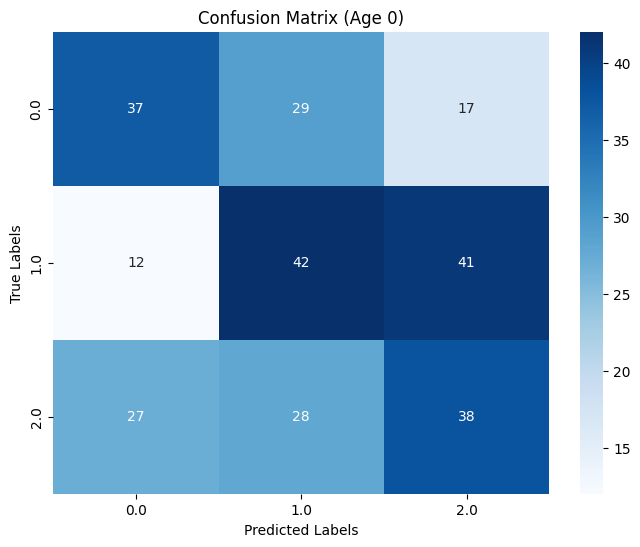

In [50]:
# catage = df_5['catage'].unique()
catage = [0]
results,selected_features_total = process_and_train_model_for_each_age(df_5, catage)


In [46]:
age0_features = ['spent_time_friend1', 'lunch_routinday', 'saltysnack', 'vegetables', 'milk', 'fastfoods', 'physical_activity_hour', 'physical_activity', 'TV_watching_routinday', 'TV_watching_friday', 'sleep_hours_routinday', 'sleep_hours_friday', 'fight_number', 'father_hookah', 'sibling_smoker', 'confusion_number', 'insomnia_number', 'back_pain_number', 'worried_number', 'anxiety_number', 'smoke_escaping_problems', 'smoke_focus', 'birth_weight', 'breast_feeding_duration', 'grains', 'liverandkalepache', 'bread', 'potato', 'friedfoods', 'fresh_fruit_nondaily', 'litigant_friend', 'litigant_parent', 'comfort_mother_nadaram', 'comfort_father_nadaram', 'comfort_sister_rahati', 'father_edu_father died', 'father_edu_graduate education', 'father_edu_illiterate', 'father_edu_intermediate', 'mother_edu_illiterate', 'father_job_unemployed', 'mother_job_farmer', 'mother_job_housewife', 'mother_job_others', 'school_type_public school', "milk_type_mother's milk and cow's milk", "milk_type_mother's milk and powdered milk", 'milk_type_powdered milk', 'bread_type_whole grain bread', 'oil_type_cooking oil', 'oil_type_lamb fat', 'dairy_type_pasteurized low-fat', 'diet_plan_no, but it should be reduced', 'diet_plan_weight is fine']
age1_features = ['catage','close_friend_count', 'spent_time_friend1', 'spent_time_friend2', 'chatting_online', 'breakfast_routindays', 'lunch_routinday', 'dinner_friday', 'saltysnack', 'milk', 'fastfoods', 'TV_watching_routinday', 'TV_watching_friday', 'computer_work_friday', 'sleep_hours_routinday', 'sleep_hours_friday', 'fight_number', 'carry_weapons', 'bully_number', 'father_hookah', 'sibling_hookah', 'others_hookah', 'father_smoker', 'confusion_number', 'worthless_number', 'back_pain_number', 'headache_number', 'worried_number', 'stomach_ache_number', 'smoke_feeling_grown_up', 'family_size', 'livingparent', 'birth_weight', 'breast_feeding_duration', 'potato', 'reduce_fast_food', 'comfort_friend_nadaram', 'comfort_brother_rahati', 'home_ownership_personal', 'home_ownership_rented', 'father_edu_diploma', 'mother_edu_diploma', 'mother_edu_illiterate', 'mother_edu_mother died', 'mother_job_housewife', 'mother_job_no job', "milk_type_mother's milk and powdered milk", 'complementary_feeding_homemade food', 'complementary_feeding_ready-made food', 'oil_type_cooking oil', 'dairy_type_pasteurized full-fat', 'region_urban', 'diet_plan_no, but it should be reduced', 'diet_plan_weight is fine', 'diet_plan_yes']
age2_features = ['close_friend_count', 'spent_time_friend1', 'spent_time_friend2', 'breakfast_routindays', 'breakfast_friday', 'lunch_routinday', 'lunch_friday', 'dinner_routinday', 'sweet', 'saltysnack', 'soda', 'dry_fruit', 'fresh_juice', 'packed_juice', 'vegetables', 'milk', 'fastfoods', 'physical_activity_hour', 'physical_activity', 'TV_watching_routinday', 'TV_watching_friday', 'computer_work_routinday', 'computer_work_friday', 'sleep_hours_routinday', 'sleep_hours_friday', 'injury_number', 'fight_number', 'carry_weapons', 'victim_number', 'bully_number', 'mother_hookah', 'father_hookah', 'sibling_hookah', 'others_hookah', 'father_smoker', 'mother_smoker', 'others_smoker', 'confusion_number', 'worthless_number', 'insomnia_number', 'back_pain_number', 'headache_number', 'worried_number', 'stomach_ache_number', 'angriness_number', 'anxiety_number', 'mental_health_overview', 'smoke_escaping_problems', 'smoke_feeling_grown_up', 'smoke_staying_awake', 'smoke_feeling_loved', 'family_size', 'car_ownership', 'computer_ownership', 'livingparent', 'birth_weight', 'breast_feeding_duration', 'fatty_dairy', 'usual_dairy', 'meat', 'liverandkalepache', 'bread', 'rice', 'potato', 'friedfoods', 'fruit_nut_substitute', 'reduce_fast_food', 'increase_vegetables', 'reduce_salt', 'reduce_fat', 'use_liquid_oil', 'injury_parent_ask', 'fresh_fruit_nondaily', 'litigant_stranger', 'comfort_friend_nadaram', 'comfort_friend_rahati', 'comfort_father_rahati', 'comfort_sister_nadaram', 'home_ownership_personal', 'home_ownership_rented', 'father_edu_diploma', 'father_edu_elementry education', 'father_edu_father died', 'father_edu_graduate education', 'father_edu_illiterate', 'father_edu_intermediate', 'mother_edu_diploma', 'mother_edu_elementry education', 'mother_edu_graduate education', 'mother_edu_illiterate', 'mother_edu_intermediate', 'father_job_farmer', 'father_job_no job', 'father_job_self-employed', 'father_job_unemployed', 'mother_job_housewife', 'mother_job_others', 'school_type_public school', "milk_type_mother's milk", "milk_type_mother's milk and cow's milk", "milk_type_mother's milk and powdered milk", 'complementary_feeding_homemade food', 'complementary_feeding_ready-made food', 'bread_type_whole grain bread', 'oil_type_cooking oil', 'oil_type_solid oil', 'dairy_type_non-pasteurized regular', 'dairy_type_pasteurized full-fat', 'dairy_type_pasteurized low-fat', 'region_urban', 'depression_no', 'diet_plan_no, but it should be reduced', 'diet_plan_yes']

In [33]:
intersection = list(set(age1_features) & set(age0_features))
print(intersection)

['oil_type_cooking oil', 'sleep_hours_friday', 'birth_weight', 'breast_feeding_duration', 'TV_watching_routinday', 'diet_plan_weight is fine', 'fastfoods', 'TV_watching_friday', 'sleep_hours_routinday', 'lunch_routinday', 'worried_number', 'spent_time_friend1', 'mother_job_housewife', 'saltysnack', 'milk', 'back_pain_number', 'confusion_number', "milk_type_mother's milk and powdered milk", 'diet_plan_no, but it should be reduced', 'fight_number', 'mother_edu_illiterate', 'potato', 'father_hookah']
